In [18]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools
import matplotlib.pyplot as plt

# Data Import

In [19]:
temp_logged = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/stair_collab/julie_temperature/Temp_data_high_tide_combined.csv')

In [20]:
temp_logged

,Water_level_m,Date_UTC,Mean_temp_C,Site,Lat,Lon
0,3.148,2024-03-19 15:00,8.971429,Cain_peninsula,48.879148,-123.312558
1,3.575,2024-03-19 16:00,9.100000,Cain_peninsula,48.879148,-123.312558
2,3.850,2024-03-19 17:00,9.171429,Cain_peninsula,48.879148,-123.312558
3,3.949,2024-03-19 18:00,9.371429,Cain_peninsula,48.879148,-123.312558
4,3.883,2024-03-19 19:00,9.471429,Cain_peninsula,48.879148,-123.312558
...,...,...,...,...,...,...
23314,3.464,2024-09-17 14:00,14.750000,Sharon_cove,49.339260,-123.223257
23315,3.365,2024-09-17 14:10,14.800000,Sharon_cove,49.339260,-123.223257
23316,3.272,2024-09-17 14:20,14.800000,Sharon_cove,49.339260,-123.223257
23317,3.163,2024-09-17 14:30,14.883333,Sharon_cove,49.339260,-123.223257


In [21]:
site_coords = temp_logged.set_index('Site')[['Lat', 'Lon']].drop_duplicates().to_dict('index')

In [22]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [34]:
model_cain = xr.open_dataset('/ocean/cdonaldson/stair_extractions/julie/SalishSeaCast_hourly_phys_00_05_cain_20240319_20240926.nc')

# Functions

In [23]:
def grid_from_latlon(lat_coord, lon_coord):
    lat_diff = np.abs(bathy.nav_lat - lat_coord)
    lon_diff  = np.abs(bathy.nav_lon - lon_coord)
    sum_of_diff = lat_diff + lon_diff
    intersect_idx = np.unravel_index(np.nanargmin(np.ma.masked_array(sum_of_diff, mask=tmask[5]).filled(np.nan)), sum_of_diff.shape)

    fig, ax = plt.subplots(1,2)
    cb = ax[0].pcolormesh(sum_of_diff)
    ax[0].set_ylabel('GridY')
    ax[0].set_xlabel('GridX')
    viz_tools.set_aspect(ax[0]);
    
    cb2 = ax[1].pcolormesh(np.ma.masked_array(sum_of_diff, mask=tmask[5]))
    ax[1].set_ylabel('GridY')
    ax[1].set_xlabel('GridX')
    viz_tools.set_aspect(ax[1]);
    ax[1].plot(intersect_idx[1], intersect_idx[0], 'r*')

    fig.colorbar(cb, ax=ax[:], label='Lat Diff + Lon Diff')

    print('(y, x): {}'.format(intersect_idx))
    print('Bathy: {} m'.format(bathy['Bathymetry'].isel(y=intersect_idx[0], x=intersect_idx[1]).values))

In [24]:
def plot_water_levels(site_name):
    temp_logged_site = temp_logged[temp_logged['Site'] == site_name]
    temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')

    fig, ax = plt.subplots(1,1)
    ax.plot(temp_logged_site['time'], temp_logged_site['Water_level_m'], '-')
    print(temp_logged_site['time'].min())
    print(temp_logged_site['time'].max())

# Work

In [25]:
site_names = temp_logged['Site'].unique()
print(site_names)

['Cain_peninsula' 'Heron_rocks' 'Heriot_bay' 'Dinner_bay' 'Halfmoon_bay'
 'Sharon_cove']


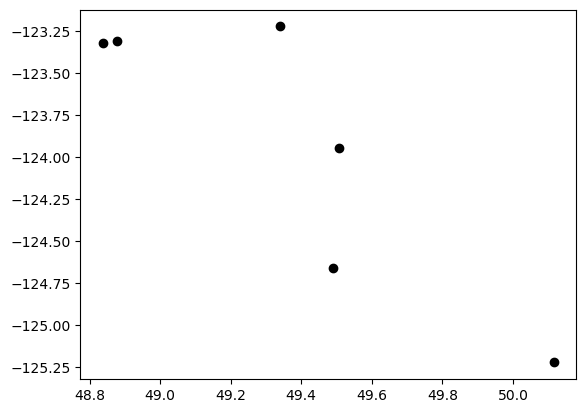

In [26]:
for site_name in site_names:    
    lat, lon = site_coords[site_name].values()
    plt.plot(lat, lon, 'ko')

## Cain Penninsula

Cain_peninsula


(y, x): (384, 263)
Bathy: 19.75 m
2024-03-19 15:00:00
2024-09-26 13:00:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


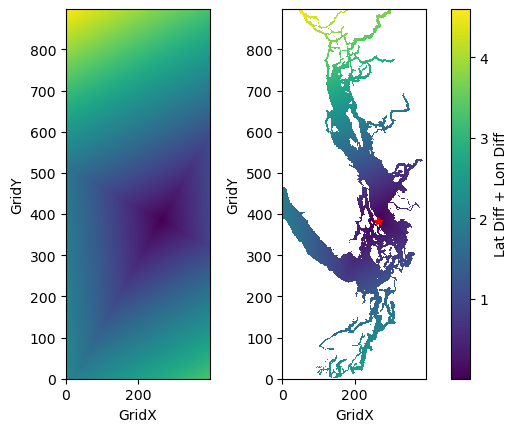

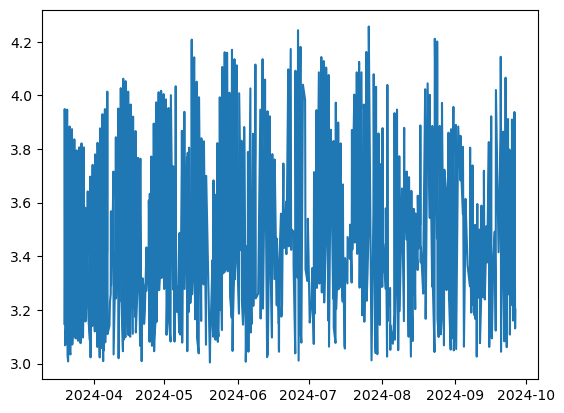

In [27]:
site_name = 'Cain_peninsula'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)

In [35]:
model_cain

<xarray.Dataset>
Dimensions:   (time: 4608, depth: 5, gridY: 0, gridX: 0)
Coordinates:
  * time      (time) datetime64[ns] 2024-03-19T00:30:00 ... 2024-09-26T23:30:00
  * depth     (depth) float32 0.5 1.5 2.5 3.5 4.5
  * gridY     (gridY) int64 
  * gridX     (gridX) int64 
Data variables:
    votemper  (time, depth, gridY, gridX) float32 ...
    vosaline  (time, depth, gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_hourly_phys_00_05_cain_20240319_20240926
    description:  Hour-averaged physics extracted from SalishSeaCast v202111 ...
    history:      2025-08-25 13:46 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

## Heron Rocks

Heron_rocks
(y, x): (599, 141)
Bathy: 19.1875 m
2024-04-06 09:30:00
2024-09-04 15:30:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


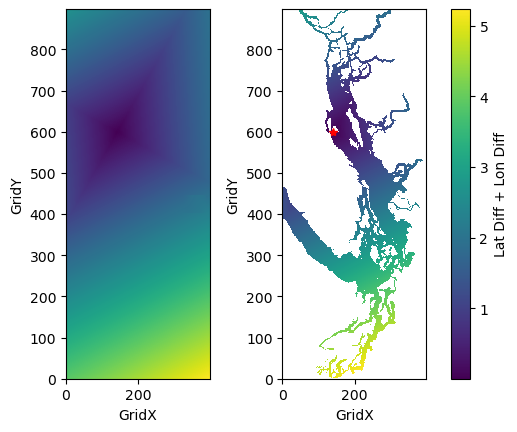

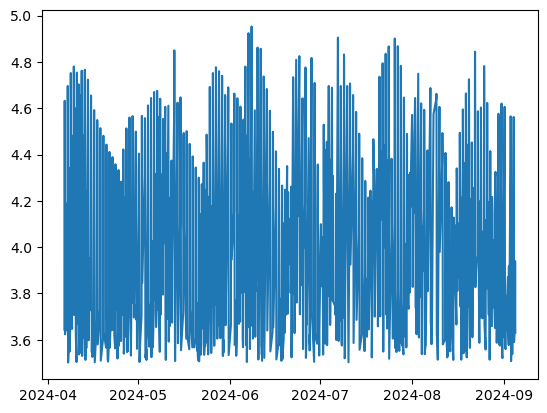

In [28]:
site_name = 'Heron_rocks'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)

## Heriot Bay

Heriot_bay
(y, x): (761, 137)
Bathy: 15.25 m
2024-07-10 02:00:00
2024-07-30 23:30:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


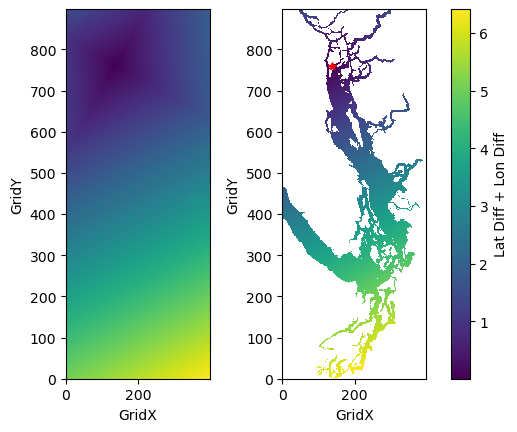

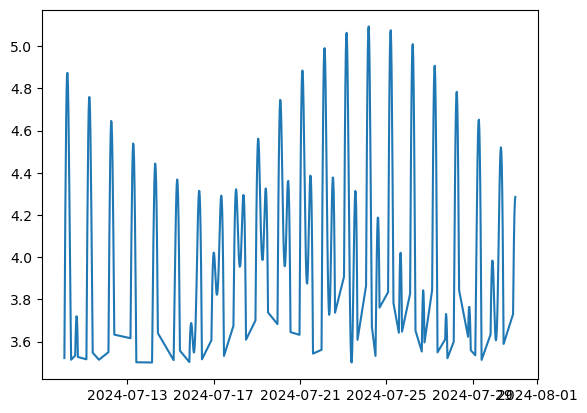

In [29]:
site_name = 'Heriot_bay'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)

## Dinner Bay

Dinner_bay
(y, x): (377, 256)
Bathy: 39.0625 m
2024-03-20 09:00:00
2024-09-27 08:30:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


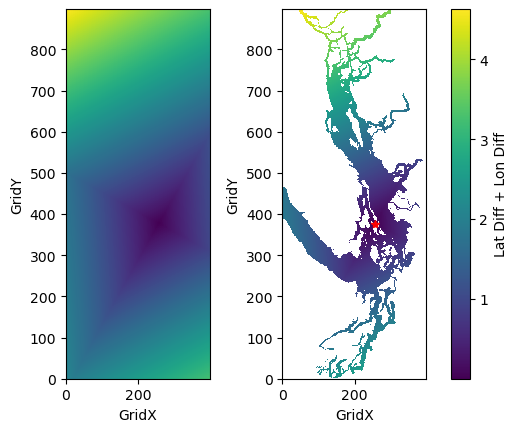

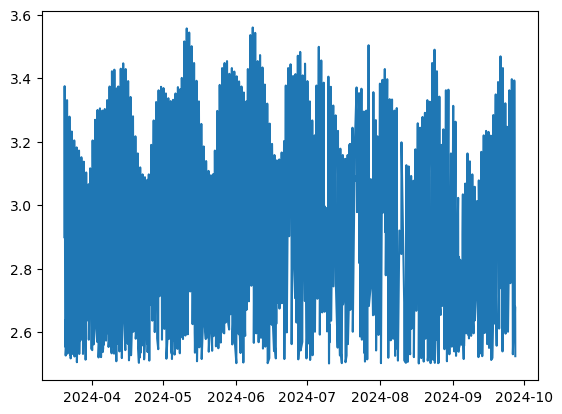

In [30]:
site_name = 'Dinner_bay'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)

## Halfmoon Bay


Halfmoon_bay
(y, x): (551, 249)
Bathy: 27.8125 m
2024-05-29 09:00:00
2024-09-15 11:30:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


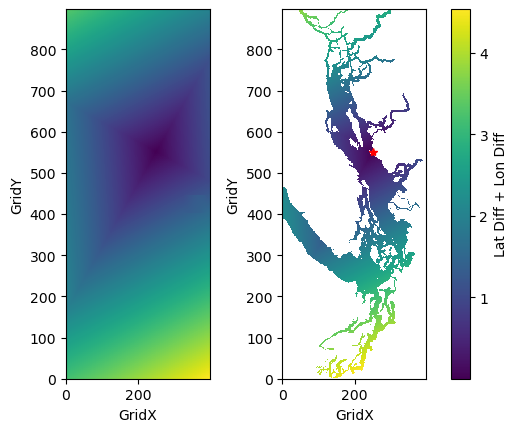

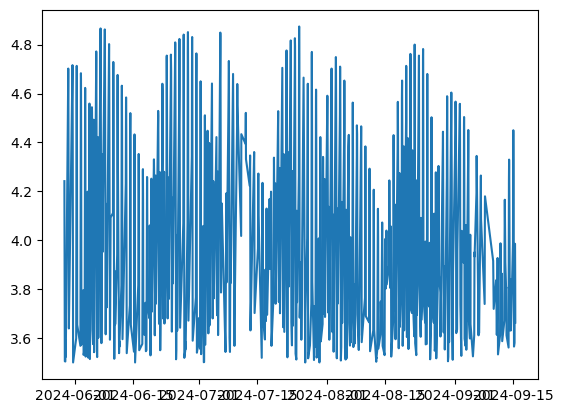

In [31]:
site_name = 'Halfmoon_bay'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)

## Sharon Cove
No Google Maps result

Sharon_cove
(y, x): (468, 334)
Bathy: 9.5625 m
2024-03-01 02:00:00
2024-09-17 14:40:00


/tmp/ipykernel_1854567/3518042275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


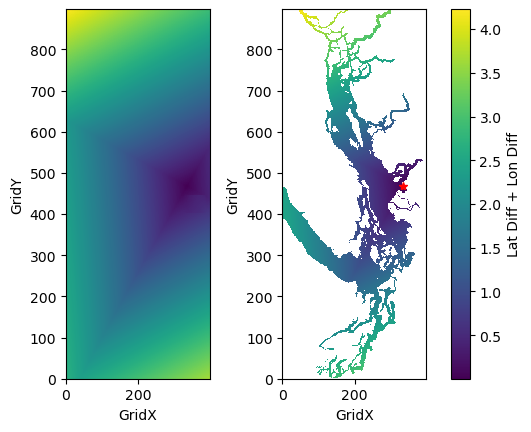

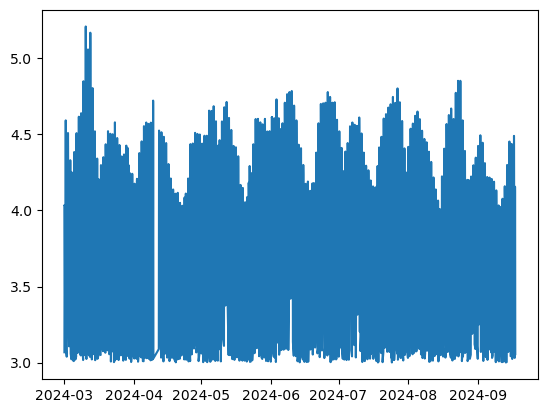

In [32]:
site_name = 'Sharon_cove'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
plot_water_levels(site_name)